In [4]:
# !gdown 1PUsf2ta0-KvVCA-UX9oUFY49FGOLpha6

In [5]:
# !unzip /content/aug_dataset.zip -d /content/aug_dataset

## Import library

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import time

## Data preprocessing

In [7]:
import tensorflow as tf
import os

DATASET_DIR = '/content/aug_dataset'

# Đường dẫn tới các thư mục lớp
class_names = ['High squamous intra-epithelial lesion', 'Low squamous intra-epithelial lesion', 'Negative for Intraepithelial malignancy', 'Squamous cell carcinoma']
data_dir = os.path.join(DATASET_DIR)

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

# Tạo dataset cho training và validation
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical'
)


Found 11544 files belonging to 4 classes.
Using 9236 files for training.
Found 11544 files belonging to 4 classes.
Using 2308 files for validation.


In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(max(1, val_batches // 5))
validation_dataset = validation_dataset.skip(max(1, val_batches // 5))

In [9]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 30
Number of test batches: 7


## Configure the dataset for performance

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Rescale pixel values

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1) # [-1, 1] or [0, 1]

## Load model feature extraction

In [12]:
# **Load the saved feature extraction model**
saved_model_path = 'mobileNet_V2_FE_Aug.keras'
model = tf.keras.models.load_model(saved_model_path)
print("Loaded model from checkpoint")

Loaded model from checkpoint


In [13]:
# **Unfreeze the top layers of the base model**
base_model = model.layers[1]  # Assuming the base_model is the second layer in the Sequential model
base_model.trainable = True

In [14]:
# Print the number of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


## Fine tuning

### Test fine-tuning

In [15]:
# base model layer
for i, layer in enumerate(base_model.layers):
    print(f"{i}: {layer.name} - Trainable: {layer.trainable}")

0: input_layer_1 - Trainable: True
1: Conv1 - Trainable: True
2: bn_Conv1 - Trainable: True
3: Conv1_relu - Trainable: True
4: expanded_conv_depthwise - Trainable: True
5: expanded_conv_depthwise_BN - Trainable: True
6: expanded_conv_depthwise_relu - Trainable: True
7: expanded_conv_project - Trainable: True
8: expanded_conv_project_BN - Trainable: True
9: block_1_expand - Trainable: True
10: block_1_expand_BN - Trainable: True
11: block_1_expand_relu - Trainable: True
12: block_1_pad - Trainable: True
13: block_1_depthwise - Trainable: True
14: block_1_depthwise_BN - Trainable: True
15: block_1_depthwise_relu - Trainable: True
16: block_1_project - Trainable: True
17: block_1_project_BN - Trainable: True
18: block_2_expand - Trainable: True
19: block_2_expand_BN - Trainable: True
20: block_2_expand_relu - Trainable: True
21: block_2_depthwise - Trainable: True
22: block_2_depthwise_BN - Trainable: True
23: block_2_depthwise_relu - Trainable: True
24: block_2_project - Trainable: True


In [16]:
fine_tuning_learning_rate = 1e-4


Fine-tuning from 20% last layer (layer 30/154)
Epoch 1/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 87s 340ms/step - accuracy: 0.9225 - loss: 0.2156 - val_accuracy: 0.8339 - val_loss: 0.6802
Epoch 2/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 35s 186ms/step - accuracy: 0.9897 - loss: 0.0317 - val_accuracy: 0.9054 - val_loss: 0.4029
Epoch 3/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.9955 - loss: 0.0134 - val_accuracy: 0.9387 - val_loss: 0.3524
Epoch 4/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 27s 187ms/step - accuracy: 0.9977 - loss: 0.0076 - val_accuracy: 0.9538 - val_loss: 0.3073
Epoch 5/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 27s 186ms/step - accuracy: 0.9972 - loss: 0.0065 - val_accuracy: 0.9591 - val_loss: 0.2079

Fine-tuning from 40% last layer (layer 61/154)
Epoch 1/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 63s 279ms/step - accuracy: 0.9986 - loss: 0.0058 - val_accuracy: 0.9360 - val_loss: 0.3472
Epoch 2/5
145/145 ━━━━━━━━━━━━━━━━━━━━ 27s 183ms/step - accuracy: 0.9993 - loss: 0.0029 - val_accuracy: 0.9683 - val_loss: 0

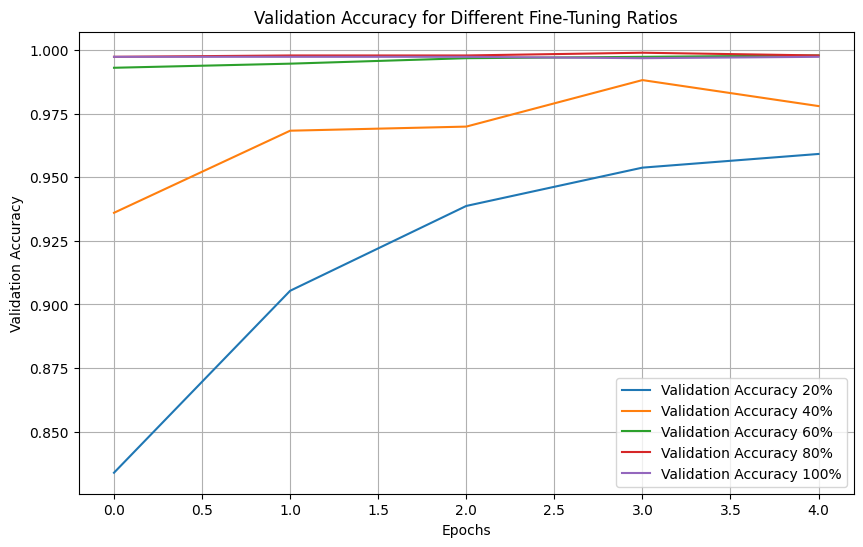

In [17]:
import matplotlib.pyplot as plt

# Các tỷ lệ phần trăm để thử nghiệm fine-tuning (cách nhau 20%)
fine_tune_ratios = [0.2, 0.4, 0.6, 0.8, 1.0]  # Fine-tune từ 20%, 40%, ... đến 100% lớp cuối

# Tổng số lớp của mô hình
total_layers = len(base_model.layers)

# Ghi lại kết quả
results = []
history_dict = {}  # Dùng để lưu history cho từng tỷ lệ fine-tuning

for ratio in fine_tune_ratios:
    # Tính số lớp bắt đầu fine-tuning
    fine_tune_at = int(total_layers * ratio)
    print(f"\nFine-tuning from {ratio*100:.0f}% last layer (layer {fine_tune_at}/{total_layers})")

    # Đặt các lớp trước fine_tune_at không trainable
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    for layer in base_model.layers[fine_tune_at:]:
        layer.trainable = True

    # Compile lại mô hình
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=fine_tuning_learning_rate),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )

    # Train trong một số epoch ngắn để đánh giá
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=5,  # Fine-tuning nhanh trong 5 epochs
        verbose=1
    )

    # Ghi lại độ chính xác validation
    val_accuracy = model.evaluate(validation_dataset, verbose=0)[1]
    results.append((fine_tune_at, ratio, val_accuracy))

    # Lưu lịch sử huấn luyện
    history_dict[ratio] = history

# Sắp xếp kết quả theo độ chính xác giảm dần
sorted_results = sorted(results, key=lambda x: x[2], reverse=True)

# Hiển thị kết quả tốt nhất
best_result = sorted_results[0]
print(f"\nBest result: Fine-tuning from {best_result[1]*100:.0f}% last layer (layer {best_result[0]}) with validation accuracy = {best_result[2]:.4f}")

# Chọn fine-tune_at với độ chính xác tốt nhất và tiếp tục train nếu cần
best_fine_tune_at = best_result[0]

# Vẽ biểu đồ Validation Accuracy cho mỗi tỷ lệ fine-tuning
plt.figure(figsize=(10, 6))

for ratio, history in history_dict.items():
    plt.plot(history.history['val_accuracy'], label=f'Validation Accuracy {ratio*100:.0f}%')

plt.title('Validation Accuracy for Different Fine-Tuning Ratios')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# Fine-tune from this layer onwards
fine_tune_at = best_fine_tune_at

model = tf.keras.models.load_model('/content/mobileNet_V2_FE_Aug.keras')

base_model = model.layers[1]  # Assuming the base_model is the second layer in the Sequential model
base_model.trainable = True

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:best_fine_tune_at]:
    layer.trainable = False

In [19]:
# **Compile the model for fine-tuning**
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=fine_tuning_learning_rate),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]
)

In [20]:
# Print model summary to confirm the trainable layers
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 1,964,292 (7.49 MB)

 Non-trainable params: 298,816 (1.14 MB)

In [21]:
print("Number of trainable variables: ", len(model.trainable_variables))

Number of trainable variables:  65


In [22]:
# **Add ModelCheckpoint callback for saving the fine-tuned model**
fine_tuned_checkpoint = ModelCheckpoint(
    filepath='mobileNet_V2_finetuned_Aug.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch'
)

In [23]:
# **Add TimeHistory callback to track epoch duration**
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        end_time = time.time()
        epoch_duration = end_time - self.start_time
        self.epoch_times.append(epoch_duration)
        print(f"Epoch {epoch + 1} duration: {epoch_duration:.2f} seconds")

In [24]:
time_callback = TimeHistory()

In [25]:
# **Continue training (fine-tuning)**
fine_tuning_epochs = 20  # Additional epochs for fine-tuning

history_fine_tuning = model.fit(
    train_dataset,
    epochs=fine_tuning_epochs,
    validation_data=validation_dataset,
    callbacks=[fine_tuned_checkpoint, time_callback]
)

# **Save final fine-tuned model**
model.save('MobileNet_V2_finetuned_final_Aug.keras')
print("Fine-tuned model saved.")


Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9348 - loss: 0.1815
Epoch 1: val_loss improved from inf to 1.45454, saving model to mobileNet_V2_finetuned_Aug.keras
Epoch 1 duration: 53.61 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 54s 258ms/step - accuracy: 0.9350 - loss: 0.1809 - val_accuracy: 0.6952 - val_loss: 1.4545
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9948 - loss: 0.0188
Epoch 2: val_loss improved from 1.45454 to 0.50823, saving model to mobileNet_V2_finetuned_Aug.keras
Epoch 2 duration: 62.20 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 62s 178ms/step - accuracy: 0.9948 - loss: 0.0188 - val_accuracy: 0.8677 - val_loss: 0.5082
Epoch 3/20
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9972 - loss: 0.0084
Epoch 3: val_loss improved from 0.50823 to 0.43202, saving model to mobileNet_V2_finetuned_Aug.keras
Epoch 3 duration: 26.78 seconds
145/145 ━━━━━━━━━━━━━━━━━━━━ 27s 185ms/step - accuracy: 0.9972 - loss: 0.0084 - val_accuracy: 0.8887 

## Learning curves

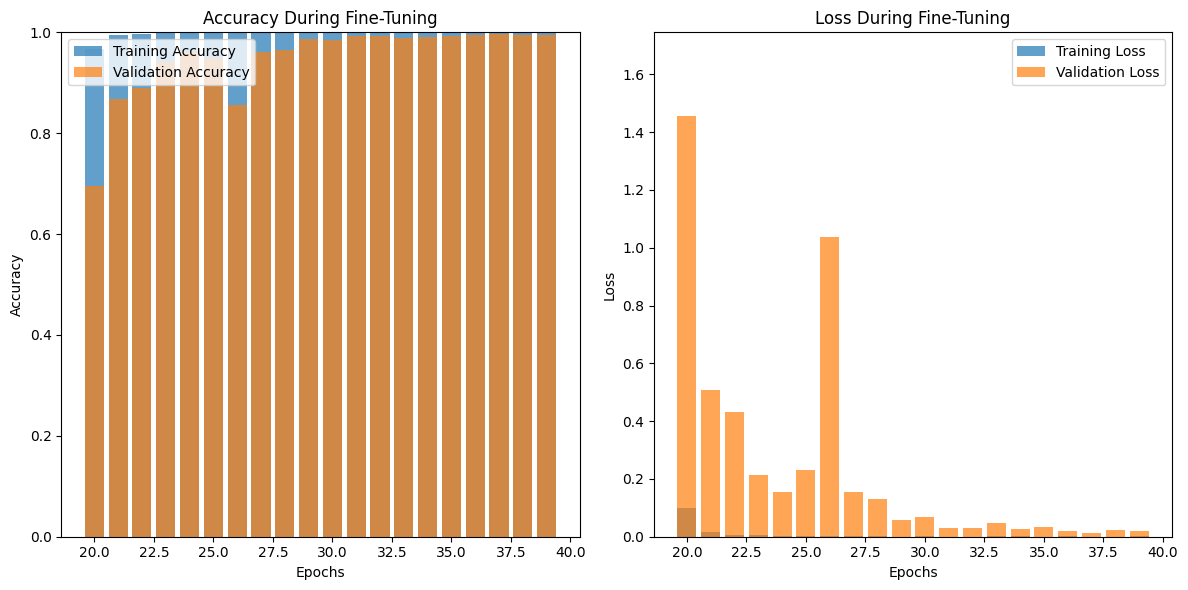

In [26]:
actual_initial_epochs = 20
# Lấy dữ liệu từ thời điểm bắt đầu fine-tuning
fine_tune_start = actual_initial_epochs  # Epoch bắt đầu fine-tuning

# Dữ liệu fine-tuning
fine_tune_acc = history_fine_tuning.history['accuracy']
fine_tune_val_acc = history_fine_tuning.history['val_accuracy']
fine_tune_loss = history_fine_tuning.history['loss']
fine_tune_val_loss = history_fine_tuning.history['val_loss']

# Vẽ biểu đồ cột cho Accuracy
epochs_range = range(fine_tune_start, fine_tune_start + len(fine_tune_acc))

plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.bar(epochs_range, fine_tune_acc, label='Training Accuracy', alpha=0.7)
plt.bar(epochs_range, fine_tune_val_acc, label='Validation Accuracy', alpha=0.7)
plt.ylim([0, 1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy During Fine-Tuning')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.bar(epochs_range, fine_tune_loss, label='Training Loss', alpha=0.7)
plt.bar(epochs_range, fine_tune_val_loss, label='Validation Loss', alpha=0.7)
plt.ylim([0, max(max(fine_tune_loss), max(fine_tune_val_loss)) * 1.2])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss During Fine-Tuning')
plt.legend()

plt.tight_layout()
plt.show()

## Time training

### Sum all of epochs

In [27]:
total_time = sum(time_callback.epoch_times)
print(f"Total time for training: {total_time:.2f} seconds")

Total time for training: 667.56 seconds


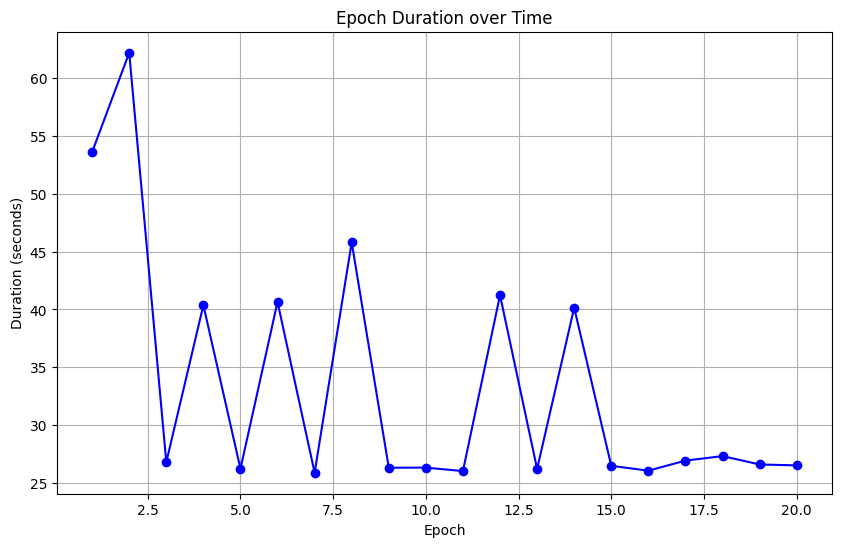

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(time_callback.epoch_times) + 1), time_callback.epoch_times, marker='o', color='b')
plt.title('Epoch Duration over Time')
plt.xlabel('Epoch')
plt.ylabel('Duration (seconds)')
plt.grid(True)
plt.show()

## Evaluation and prediction

In [29]:
# Evaluate on test dataset
loss, accuracy = model.evaluate(test_dataset)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9982 - loss: 0.0029
Test loss: 0.0037159898784011602
Test accuracy: 0.9977678656578064


Predicted classes:
 [2 0 1 0 3 2 2 2 2 2 1 2 2 2 3 2 2 2 2 2 2 2 1 2 2 2 1 2 1 2 3 2 1 2 2 2 2
 3 2 0 0 2 2 2 1 2 2 2 2 0 2 2 0 2 2 2 2 2 2 2 0 2 2 1]
True classes:
 [2 0 1 0 3 2 2 2 2 2 1 2 2 2 3 2 2 2 2 2 2 2 1 2 2 2 1 2 1 2 3 2 1 2 2 2 2
 3 2 0 0 2 2 2 1 2 2 2 2 0 2 2 0 2 2 2 2 2 2 2 0 2 2 1]


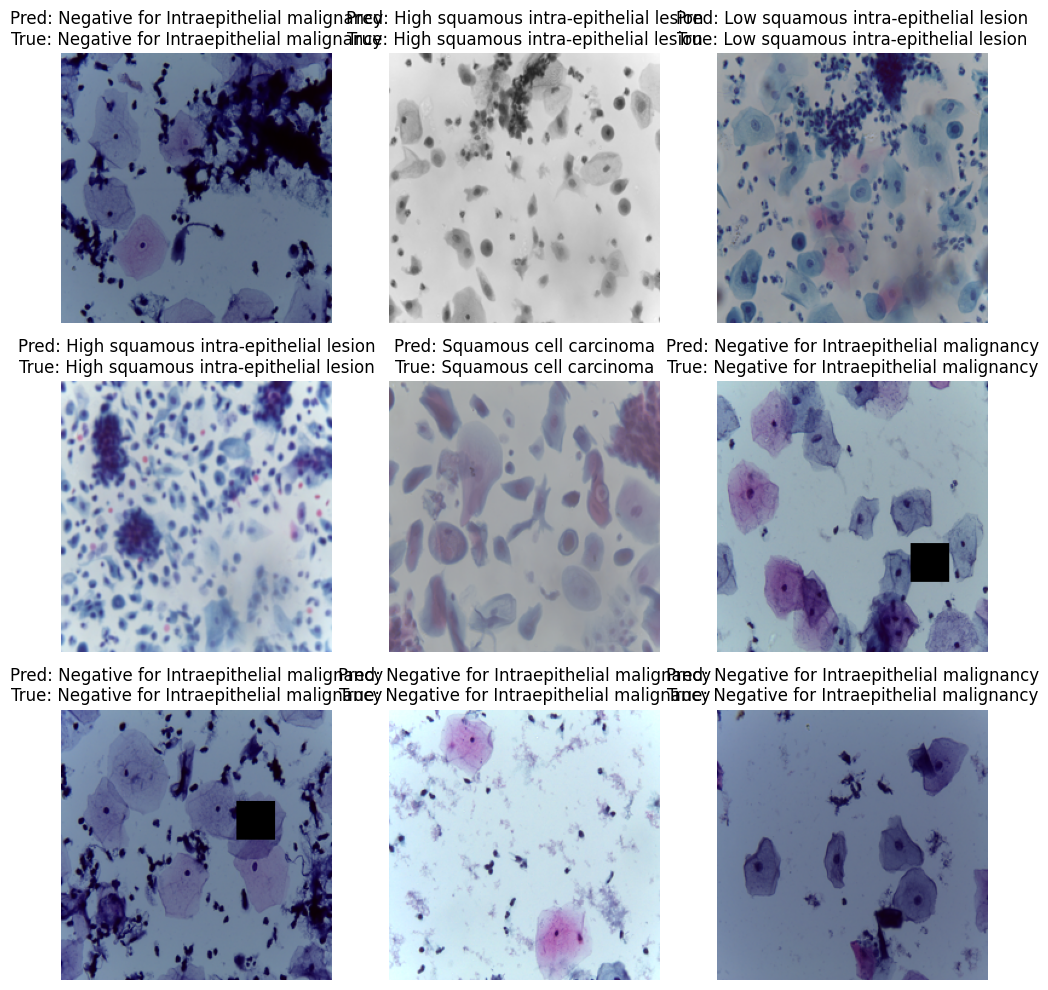

In [30]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Lấy chỉ số lớp dự đoán cao nhất
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(label_batch, axis=1)

print('Predicted classes:\n', predicted_classes)
print('True classes:\n', true_classes)

# Plot images with predictions
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"Pred: {class_names[predicted_classes[i]]}\nTrue: {class_names[true_classes[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()